# Scona Tutorial part2 Visulation of metrics and differences.

In part one the tutorial went through how to create a graph, get metrics and plot using nilearn the graph.

In this tutorial we will concentrate more of visualising the metrics.

## Getting the data and making a graph

This has been done in part one so I won't go into any detail

1. Import modules
2. Get the data
3. Create a correlation matrix
4. Create a graph 
5. Threshold the graph

In [34]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import scona as scn
from scona.visualisations import plot_network_measures, plot_degree_dist, plot_rich_club
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

This code creates the enviornmental variable for where the data is stored. Create a .env file in the directory with the file path to data.

In [ ]:
from decouple import config

data = config('data')

In [2]:
lh_area = pd.read_csv(f'{data}/lh_area.dat',sep='\t').drop(['lh_WhiteSurfArea_area',
       'BrainSegVolNotVent', 'eTIV'],axis=1).rename(columns={'lh.aparc.area':'G-Number'})

rh_area =  pd.read_csv(f'{data}/rh_area.dat',sep='\t').drop(['rh_WhiteSurfArea_area',
       'BrainSegVolNotVent', 'eTIV','rh.aparc.area'],axis=1)

group = pd.read_csv(f'{data}/cortical_measures.csv').iloc[0:,2]

area = pd.concat([lh_area, rh_area, group],axis=1)

names = list(area.columns.drop(['G-Number','age_adjusted_group']))

centroids = pd.read_csv(f'{data}/atlas.csv') #This atlas was obtained from braingraph R package

centroids = centroids[['x.mni', 'y.mni', 'z.mni']].to_numpy()

group = area.groupby('age_adjusted_group')
aan = group.get_group('AAN').reset_index(drop=True)
hc = group.get_group('HC').reset_index(drop=True)
wr = group.get_group('WR').reset_index(drop=True)

In [3]:
aan_residuals_df = scn.create_residuals_df(aan.iloc[:,1:69], names)
aan_corr_matrix = scn.create_corrmat(aan_residuals_df, method='pearson')

In [9]:
aan_graph = scn.BrainNetwork(network=aan_corr_matrix, parcellation=names, centroids=centroids)
aan_graph_threshold = aan_graph.threshold(10)

Next we create the GraphBundle object and create a 1000 random graphs

In [5]:
brain_bundle = scn.GraphBundle([aan_graph_threshold], ['AAN_graph_thresholded'])
brain_bundle.create_random_graphs('AAN_graph_thresholded', 1000)

        Creating 1000 random graphs - may take a little while


## Visulising the degree distribution.

The degree of each node is the number of edges adjacent to each node (if there are 4 nodes adjacent to a node then the degree is 4, 50 if it is connected to 50 nodes).

Brain networks are usually scale free meaning that there are a small number of nodes that have relatively large number of connections (it follows a power law), so has a heavy tail (see the graph).

The Erdős–Rényi graph is an example of a binomial graph (the probability of connections is in a binomial, i.e yes-no) that is opposite to a scale free grapth. The brain network degree distrubtion is checked against the Erdős–Rényi graph.

### Checking degree distribution

First thing to do is to check if the brain network is scale free.

This is done by:

1. Calculating the degree of each node.


In [11]:
aan_graph_threshold.calculate_nodal_measures()
nodal_df = aan_graph_threshold.report_nodal_measures()
nodal_df.head()

,name,centroids,x,y,z,module,degree,closeness,betweenness,shortest_path_length,clustering,participation_coefficient
0,lh_bankssts_area,"[-56.0, -44.0, 5.0]",-56.0,-44.0,5.0,0,3,0.354497,0.001078,2.779412,0.666667,0.555556
1,lh_caudalanteriorcingulate_area,"[-2.0, 21.0, 27.0]",-2.0,21.0,27.0,1,5,0.376404,0.001227,2.617647,0.5,0.64
2,lh_caudalmiddlefrontal_area,"[-45.0, 18.0, 46.0]",-45.0,18.0,46.0,2,8,0.403614,0.015051,2.441176,0.464286,0.609375
3,lh_cuneus_area,"[-1.0, -82.0, 20.0]",-1.0,-82.0,20.0,3,5,0.328431,0.000207,3.0,0.8,0.0
4,lh_entorhinal_area,"[-16.0, -10.0, -29.0]",-16.0,-10.0,-29.0,1,2,0.283898,0.029851,3.470588,0,0.0


2. Checking the data.
THis can be done by printing out the head of a dataframe or cycling through the nodes

In [15]:
for degree in range(len(nodal_df['degree'])):
    if degree % 20 == 0:
        print(f'Node number {degree} degree is', nodal_df['degree'].iloc[degree])

Node number 0 degree is 3
Node number 20 degree is 13
Node number 40 degree is 1
Node number 60 degree is 14


3. Plotting the data. 

This can be done against a Erdős–Rényi graph probability distribution (default) as well as without (use binomial_graph=False). 

NOTE scona graphs have to be imported seperately and cannot be accessed by scn.visualisations (they are wrappers around seaborn)

Graphs can also be saved by using the figure_name parameter and the color can be changed using the color parameter.

/home/wmda/env/anaconda3/envs/scn/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


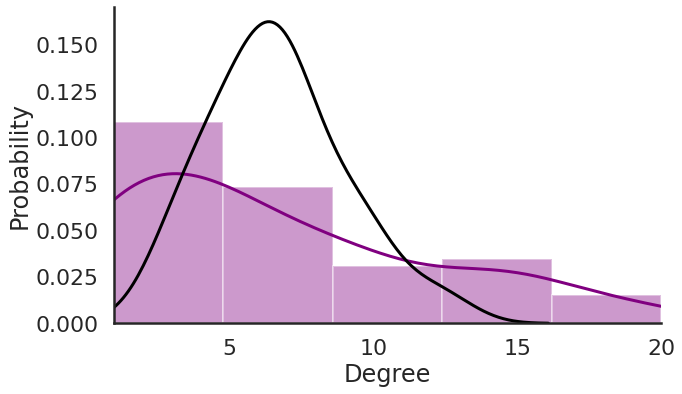

In [21]:
plot_degree_dist(aan_graph_threshold, color=["purple", "black"])

/home/wmda/env/anaconda3/envs/scn/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


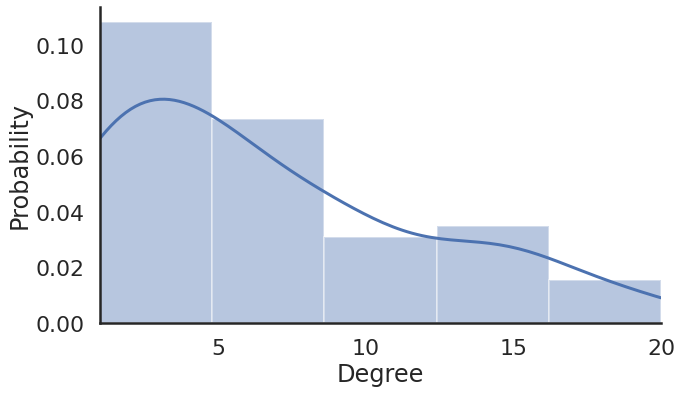

In [20]:
plot_degree_dist(aan_graph_threshold, binomial_graph=False)

## Plotting global measures.

We need to check if the global atrributes of the network differ from those of a random graph. 

This is done by:

1. Calculating the global measures for the random graphs.

In [22]:
random_graph_measures = brain_bundle.report_global_measures()
random_graph_measures.head()

,average_clustering,average_shortest_path_length,assortativity,modularity,efficiency
AAN_graph_thresholded,0.345704,2.814311,0.147443,0.371922,0.428125
AAN_graph_thresholded_R0,0.169907,2.458736,-0.032909,0.274440,0.463623
AAN_graph_thresholded_R1,0.161363,2.516681,-0.081161,0.262100,0.458736
AAN_graph_thresholded_R2,0.213430,2.477612,-0.126091,0.291022,0.462167
AAN_graph_thresholded_R3,0.176274,2.482880,-0.144126,0.292619,0.462409


In [23]:
random_graph_measures.shape

(1001, 5)

2. Plot the global measures to check for a difference.

This plots:

a = assortativity

C = clustering

E = efficiency

L = longest path

M = modularity

sigma = small world

Note figures can be saved using the figure_name parameter.

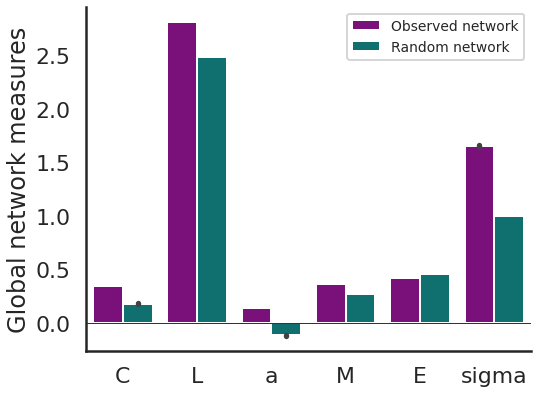

In [33]:
plot_network_measures(brain_bundle, original_network='AAN_graph_thresholded', color=['darkmagenta','teal'], ci=95)

## Rich club

The rich club refers to the extent which nodes with the highest degrees are preferntially connected to each other. It is named the rich club as many other networks also exihibit this tendency (rich people tend to trade with each other etc).

In brain networks highly connected hubs may also be the one co-rodinating complex actions so need to connect with each other to efficiently send messages to different specialised regions.

To calculate the rich club it can be done like:


In [35]:
rich_club_df = brain_bundle.report_rich_club()
rich_club_df.head()

,AAN_graph_thresholded,AAN_graph_thresholded_R0,AAN_graph_thresholded_R1,AAN_graph_thresholded_R2,AAN_graph_thresholded_R3,AAN_graph_thresholded_R4,AAN_graph_thresholded_R5,AAN_graph_thresholded_R6,AAN_graph_thresholded_R7,AAN_graph_thresholded_R8,...,AAN_graph_thresholded_R990,AAN_graph_thresholded_R991,AAN_graph_thresholded_R992,AAN_graph_thresholded_R993,AAN_graph_thresholded_R994,AAN_graph_thresholded_R995,AAN_graph_thresholded_R996,AAN_graph_thresholded_R997,AAN_graph_thresholded_R998,AAN_graph_thresholded_R999
0,0.100088,0.100088,0.100088,0.100088,0.100088,0.100088,0.100088,0.100088,0.100088,0.100088,...,0.100088,0.100088,0.100088,0.100088,0.100088,0.100088,0.100088,0.100088,0.100088,0.100088
1,0.149546,0.149546,0.149546,0.149546,0.149546,0.149546,0.149546,0.149546,0.149546,0.149546,...,0.149546,0.149546,0.149546,0.149546,0.149546,0.149546,0.149546,0.149546,0.149546,0.149546
2,0.169796,0.168163,0.168163,0.168163,0.168980,0.168163,0.168163,0.168163,0.168163,0.168163,...,0.168163,0.168163,0.169796,0.168980,0.168980,0.168163,0.168163,0.168163,0.168980,0.168163
3,0.206131,0.199789,0.198732,0.200846,0.200846,0.199789,0.198732,0.199789,0.202960,0.200846,...,0.199789,0.198732,0.201903,0.200846,0.199789,0.199789,0.199789,0.198732,0.200846,0.200846
4,0.230769,0.223077,0.224359,0.225641,0.225641,0.223077,0.221795,0.224359,0.228205,0.223077,...,0.225641,0.220513,0.226923,0.223077,0.223077,0.223077,0.221795,0.225641,0.223077,0.223077


### Visualising the rich club

The rich club needs to be different from the random graph. To check that there is a difference the rich club co-efficient can be plotted.

**NOTE** At low degree and high degree values the rich club co-efficient will be the same as the random graph. This is because:

- When modelling the random graph at higher degrees we are keeping the degree distribution however are just switiching the nodes. So the rich club co-effiencency will either be 1 (max) or 0 (min).
- When modelling the random graph at lower degrees the whole graph cannot be in the rich club so the rich-club coffiency will be similar.

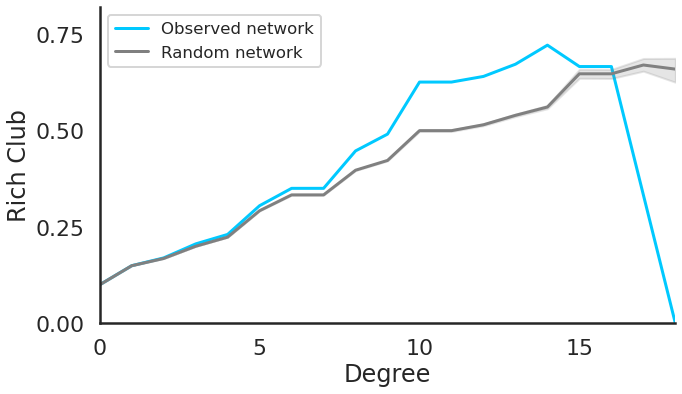

In [36]:
plot_rich_club(brain_bundle, original_network='AAN_graph_thresholded')